# Notebook on research put-call parity

In [287]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
import seaborn as sns
import statsmodels.formula.api as sm
import plotly.graph_objects as go
import datetime
from utils import get_human_timestamp
import plotly
import plotly.graph_objs as go
import plotly.express as px
from sklearn.linear_model import LinearRegression
from plotly.subplots import make_subplots


In [2]:
df = pd.read_csv(f"./datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")
data = df.copy()

## Отбираем нужные колонки и опционы только на одну криптовалюту

In [91]:
def preprocess_data(df: pd.DataFrame, currency: str  = "BTC"):
    ind = [symbol.startswith(currency) for symbol in df.symbol]
    needed_columns = ["timestamp", "type", "strike_price", "expiration", "mark_price", "underlying_price"]
    data = df[ind].reset_index(drop=True)[needed_columns]
    data["human_expiration"] = data["expiration"].apply(get_human_timestamp)
    data["human_timestamp"] = data["timestamp"].apply(get_human_timestamp)
    return data

In [92]:
single_currency_chain = preprocess_data(data)

In [93]:
single_currency_chain

timestamp  type  strike_price        expiration  mark_price  \
0         1669852800273000   put         17250  1669881600000000      0.0095   
1         1669852800273000  call         17500  1671177600000000      0.0377   
2         1669852800302000  call         16500  1669881600000000      0.0393   
3         1669852800324000  call         16500  1669881600000000      0.0393   
4         1669852800402000   put        250000  1672387200000000     13.5643   
...                    ...   ...           ...               ...         ...   
10432075  1669939199983000  call         34000  1672387200000000      0.0004   
10432076  1669939199983000  call         10000  1695974400000000      0.4728   
10432077  1669939199984000  call          5000  1680249600000000      0.7089   
10432078  1669939199988000  call         13500  1670572800000000      0.2059   
10432079  1669939199983000  call         18000  1688112000000000      0.1686   

          underlying_price            human_expiration  \
0               17165.5125  2022-12-01 11:00:00.000000   
1               17162.3600  2022-12-16 11:00:00.000000   
2               17165.5125  2022-12-01 11:00:00.000000   
3               17165.5125  2022-12-01 11:00:00.000000   
4               17164.6600  2022-12-30 11:00:00.000000   
...                    ...                         ...   
10432075        16953.1600  2022-12-30 11:00:00.000000   
10432076        16962.0900  2023-09-29 11:00:00.000000   
10432077        16946.2200  2023-03-31 11:00:00.000000   
10432078        16975.1700  2022-12-09 11:00:00.000000   
10432079        16947.9900  2023-06-30 11:00:00.000000   

                     human_timestamp  
0         2022-12-01 03:00:00.273000  
1         2022-12-01 03:00:00.273000  
2         2022-12-01 03:00:00.302000  
3         2022-12-01 03:00:00.324000  
4         2022-12-01 03:00:00.402000  
...                              ...  
10432075  2022-12-02 02:59:59.983000  
10432076  2022-12-02 02:59:59.983000  
10432077  2022-12-02 02:59:59.984000  
10432078  2022-12-02 02:59:59.988000  
10432079  2022-12-02 02:59:59.983000  

[10432080 rows x 8 columns]

In [153]:
def plot_single_expiration(df: pd.DataFrame, strike_given: int = False, expiration_date_given: int = False) -> None:
    # select options with similar expiration date
    single_expiration_date = df.sample(1).iloc[0]["expiration"]
    single_expiration_date_human = get_human_timestamp(single_expiration_date)
    single_expiration_date = expiration_date_given if expiration_date_given else single_expiration_date
    single_expiration_df = df[df["expiration"] == single_expiration_date].copy()
    
    # select options with similar strikes
    single_strike = single_expiration_df.sample(1).iloc[0]["strike_price"]
    single_strike = strike_given if strike_given else single_strike
    single_strike_df = single_expiration_df[single_expiration_df["strike_price"] == single_strike].copy()
    
    #divide by calls and puts and merge
    calls = single_strike_df[single_strike_df["type"] == "call"]
    calls["call_price_usd"] = calls["underlying_price"]*calls["mark_price"]
    puts = single_strike_df[single_strike_df["type"] == "put"]
    puts["put_price_usd"] = puts["underlying_price"]*puts["mark_price"]
    calls = calls.rename(columns = {"mark_price": "call_price"})[["timestamp", "call_price", 
        "strike_price", "underlying_price", "human_timestamp", "call_price_usd"]].copy()
    puts = puts.rename(columns = {"mark_price": "put_price"})[["timestamp", "put_price", "put_price_usd"]].copy()
    result = calls.merge(puts, on = "timestamp")
    result["parity"] = result["underlying_price"] - result["call_price_usd"] + result["put_price_usd"]
    
    # plotting
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=result["human_timestamp"], y=result["call_price_usd"], name='call price, usd'))
    fig.add_trace(go.Scatter(x=result["human_timestamp"], y=result["put_price_usd"], name='put price, usd'))
    fig.add_trace(go.Scatter(x=result["human_timestamp"], y=result["underlying_price"], name='underlying price, usd'))
    fig.add_trace(go.Scatter(x=result["human_timestamp"], y=result["parity"], name='parity'))
    # fig.add_trace(go.Scatter(x=result["human_timestamp"], y=result["strike_price"], name='strike'))
    fig.update_layout(title=f"Strike: {single_strike} USD, expiration: {single_expiration_date_human}")
    fig.show()
    
    return result


In [261]:
final_df = plot_single_expiration(single_currency_chain)

In [155]:
# fixed date and strike
final_df = plot_single_expiration(single_currency_chain, strike_given=10000, expiration_date_given = 1695974400000000)

## Dependency $call - put ~ \beta(f - S) + \alpha$

In [223]:
# tick_time = data.sample(1).timestamp.iloc[0]
# tick_all_options = data[(data["timestamp"]>=tick_time-100000) & (data["timestamp"]<=tick_time+100000)] 
tick_all_options = data[data["timestamp"] == 1669852829604000]
single_expiration = tick_all_options[tick_all_options["expiration"] == tick_all_options.sample(1).expiration.iloc[0]]
single_expiration

exchange                symbol         timestamp   local_timestamp  type  \
7221  deribit   BTC-30DEC22-32000-C  1669852829604000  1669852829607984  call   
7222  deribit   BTC-30DEC22-25000-P  1669852829604000  1669852829610705   put   
7223  deribit   BTC-30DEC22-24000-P  1669852829604000  1669852829611062   put   
7224  deribit   BTC-30DEC22-23000-C  1669852829604000  1669852829611841  call   
7225  deribit   BTC-30DEC22-22000-C  1669852829604000  1669852829613821  call   
...       ...                   ...               ...               ...   ...   
8307  deribit   BTC-30DEC22-17000-P  1669852829604000  1669852830591546   put   
8308  deribit  BTC-30DEC22-150000-P  1669852829604000  1669852830591652   put   
8309  deribit   BTC-30DEC22-15000-P  1669852829604000  1669852830591785   put   
8310  deribit   BTC-30DEC22-14000-P  1669852829604000  1669852830591835   put   
8312  deribit  BTC-30DEC22-100000-P  1669852829604000  1669852830591948   put   

      strike_price        expiration  open_interest  last_price  bid_price  \
7221         32000  1672387200000000          799.5      0.0005     0.0005   
7222         25000  1672387200000000         1670.5      0.5110     0.2010   
7223         24000  1672387200000000          771.1      0.4655     0.1500   
7224         23000  1672387200000000         1939.3      0.0035     0.0030   
7225         22000  1672387200000000         2080.9      0.0056     0.0045   
...            ...               ...            ...         ...        ...   
8307         17000  1672387200000000         2064.9      0.0595     0.0590   
8308        150000  1672387200000000            0.0         NaN        NaN   
8309         15000  1672387200000000         6343.8      0.0235     0.0230   
8310         14000  1672387200000000         4161.9      0.0160     0.0150   
8312        100000  1672387200000000            1.1      1.4900     0.1000   

      bid_amount  bid_iv  ask_price  ask_amount  ask_iv  mark_price  mark_iv  \
7221         5.8   84.97     0.0010        40.8   92.05      0.0007    88.22   
7222         0.3     NaN        NaN         NaN     NaN      0.4586    66.44   
7223         0.2     NaN     0.9445       100.0  500.00      0.4008    62.92   
7224        49.2   58.57     0.0035         0.2   60.30      0.0035    60.14   
7225        62.1   55.91     0.0055        39.9   58.44      0.0050    57.26   
...          ...     ...        ...         ...     ...         ...      ...   
8307         2.0   56.59     0.0605        30.1   57.93      0.0594    56.93   
8308         NaN     NaN        NaN         NaN     NaN      7.7399   130.35   
8309        44.3   64.64     0.0235         2.5   65.26      0.0235    65.26   
8310        18.5   71.40     0.0160        34.6   73.01      0.0156    72.39   
8312         0.1     NaN        NaN         NaN     NaN      4.8266   130.35   

     underlying_index  underlying_price    delta    gamma      vega     theta  \
7221      BTC-30DEC22          17162.62  0.00899  0.00001   1.18177  -1.77716   
7222      BTC-30DEC22          17162.62 -0.97148  0.00002   3.17458  -3.59507   
7223      BTC-30DEC22          17162.62 -0.96334  0.00003   3.90507  -4.18798   
7224      BTC-30DEC22          17162.62  0.05134  0.00004   5.12512  -5.25375   
7225      BTC-30DEC22          17162.62  0.07372  0.00005   6.79754  -6.63426   
...               ...               ...      ...      ...       ...       ...   
8307      BTC-30DEC22          17162.69 -0.44445  0.00014  19.22168 -18.65137   
8308      BTC-30DEC22          17162.62 -1.00000  0.00000   0.00000   0.00000   
8309      BTC-30DEC22          17162.69 -0.20596  0.00009  13.86233 -15.42057   
8310      BTC-30DEC22          17162.62 -0.13672  0.00006  10.65591 -13.14781   
8312      BTC-30DEC22          17162.62 -1.00000  0.00000   0.00053  -0.00118   

            rho  
7221    0.11439  
7222  -19.72464  
7223  -18.81578  
7224    0.66058  
7225    0.94763  
...         ...  
8307   -6.94915  
8308 -120.54795  

In [224]:
calls = tick_all_options[tick_all_options["type"] == "call"][["underlying_price", "strike_price", "mark_price"]]
puts = tick_all_options[tick_all_options["type"] == "put"][["strike_price", "mark_price"]]
calls = calls.rename(columns = {"mark_price": "call_price"})
puts = puts.rename(columns = {"mark_price": "put_price"})
result = calls.merge(puts, on = "strike_price")
result["call_price"] = result["call_price"]*result["underlying_price"]
result["put_price"] = result["put_price"]*result["underlying_price"]

result

underlying_price  strike_price  call_price      put_price
0            17162.62         32000   12.013834   15044.752692
1            17162.62         32000   12.013834   14849.098824
2            17162.62         32000   12.013834   15044.752692
3            17162.62         32000   12.013834   14849.098824
4            17162.62         23000   60.069170    5897.076232
..                ...           ...         ...            ...
160          17162.62        150000    0.000000  132850.692634
161          17162.62        150000    0.000000  132850.692634
162          17162.62        150000    0.000000  132836.962538
163          17162.62        100000    0.000000   82859.413098
164          17162.62        100000    0.000000   82837.101692

[165 rows x 4 columns]

In [244]:
result["x"] = - result["underlying_price"] + result["strike_price"]
result["y"] = - result["call_price"] + result["put_price"]

In [265]:
result

underlying_price  strike_price  call_price      put_price          x  \
0            17162.62         32000   12.013834   15044.752692   14837.38   
1            17162.62         32000   12.013834   14849.098824   14837.38   
2            17162.62         32000   12.013834   15044.752692   14837.38   
3            17162.62         32000   12.013834   14849.098824   14837.38   
4            17162.62         23000   60.069170    5897.076232    5837.38   
..                ...           ...         ...            ...        ...   
160          17162.62        150000    0.000000  132850.692634  132837.38   
161          17162.62        150000    0.000000  132850.692634  132837.38   
162          17162.62        150000    0.000000  132836.962538  132837.38   
163          17162.62        100000    0.000000   82859.413098   82837.38   
164          17162.62        100000    0.000000   82837.101692   82837.38   

                 y  
0     15032.738858  
1     14837.084990  
2     15032.738858  
3     14837.084990  
4      5837.007062  
..             ...  
160  132850.692634  
161  132850.692634  
162  132836.962538  
163   82859.413098  
164   82837.101692  

[165 rows x 6 columns]

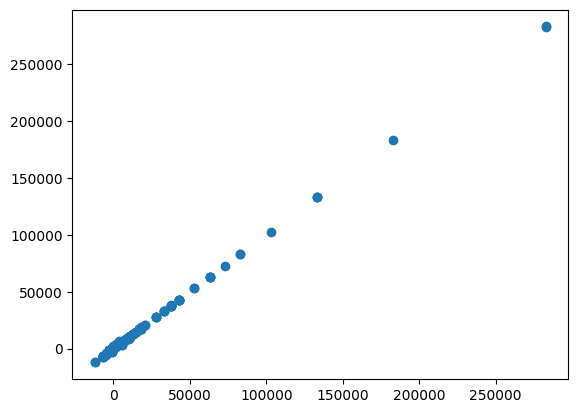

In [266]:
plt.scatter(result["x"], result["y"])

In [291]:
# idxmax
# result = result.groupby("strike_price")

In [253]:
lr.intercept_

125.32802268406886

In [249]:
lr.coef_

array([0.99842947])

In [288]:
results = sm.ols(formula='y~x',data =result[["x", "y"]]).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.980e+05
Date:                Tue, 17 Jan 2023   Prob (F-statistic):          5.64e-286
Time:                        19:33:21   Log-Likelihood:                -1323.1
No. Observations:                 165   AIC:                             2650.
Df Residuals:                     163   BIC:                             2656.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    125.3280     63.818      1.964      0.051      -0.689     251.345
x              0.9984      0.001    705.708      0.000       0.996       1.001
==============================================================================
Omnibus:                       18.483   Durbin-Watson:                   1.303
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.744
Skew:                           0.294   Prob(JB):                     1.75e-13
Kurtosis:                       5.864   Cond. No.                     5.00e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""